In [1]:
!python -m spacy download en_core_web_sm --quiet
!pip install pyLDAvis --quiet
!pip install chart_studio --quiet
!pip install profanity_filter --quiet

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 1.6MB 6.7MB/s 
     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 9.2MB 7.7MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 665kB 54.1MB/s 


In [2]:
import pandas as pd
import numpy as np
import time
import re
import string
import warnings
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import spacy
from profanity_filter import ProfanityFilter
from spacy.lang.en.stop_words import STOP_WORDS
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from spacy.tokenizer import Tokenizer
import gensim.corpora as corpora
from gensim.models.ldamulticore import LdaMulticore
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
import plotly.express as px
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls
from operator import itemgetter
from ipywidgets import interact
import tqdm
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets


# supress warnings
warnings.filterwarnings("ignore")

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# load in scraped tweets from https://github.com/tarrantcarter/Final_Capstone/blob/main/Modern_Motivation_Web_Scrape.ipynb
tweets = pd.read_json(
    r"/content/drive/MyDrive/Data/NLP_Capstone/motivational_tweets.json",
)

In [7]:
tweets.head()

,index,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,0,https://twitter.com/LewisHowes/status/13515332...,2021-01-19 14:13:23,My guest @MrJamesNestor has spent years in lab...,My guest @MrJamesNestor has spent years in lab...,1351533215459258369,"{'username': 'LewisHowes', 'displayname': 'Lew...",[https://link.chtbl.com/1060-tw],[https://t.co/xMjUvSkJtD],3,4,25,1,1351533215459258369,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,[{'thumbnailUrl': 'https://pbs.twimg.com/ext_t...,NaN,None,"[{'username': 'MrJamesNestor', 'displayname': ..."
1,1,https://twitter.com/LewisHowes/status/13515234...,2021-01-19 13:34:33,"@EDGcoach Thanks, I appreciate it! ❤","@EDGcoach Thanks, I appreciate it! ❤",1351523443234263045,"{'username': 'LewisHowes', 'displayname': 'Lew...",[],[],1,0,1,0,1351168601496150023,en,"<a href=""http://www.zendesk.com"" rel=""nofollow...",http://www.zendesk.com,Zendesk,None,NaN,None,"[{'username': 'EDGcoach', 'displayname': 'Empo..."
2,2,https://twitter.com/LewisHowes/status/13514478...,2021-01-19 08:34:12,@imchrisjordan 💯,@imchrisjordan 💯,1351447858629799940,"{'username': 'LewisHowes', 'displayname': 'Lew...",[],[],0,0,0,0,1351051353116831745,und,"<a href=""http://www.zendesk.com"" rel=""nofollow...",http://www.zendesk.com,Zendesk,None,NaN,None,"[{'username': 'imchrisjordan', 'displayname': ..."
3,3,https://twitter.com/LewisHowes/status/13514317...,2021-01-19 07:30:13,@MKenkadze Glad you loved it!,@MKenkadze Glad you loved it!,1351431756688347137,"{'username': 'LewisHowes', 'displayname': 'Lew...",[],[],0,0,1,0,1350102468126883842,en,"<a href=""http://www.zendesk.com"" rel=""nofollow...",http://www.zendesk.com,Zendesk,None,NaN,None,"[{'username': 'MKenkadze', 'displayname': 'Mar..."
4,4,https://twitter.com/LewisHowes/status/13514300...,2021-01-19 07:23:25,@sueizzo My pleasure! ❤,@sueizzo My pleasure! ❤,1351430042384003072,"{'username': 'LewisHowes', 'displayname': 'Lew...",[],[],0,0,0,0,1351040232003612673,en,"<a href=""http://www.zendesk.com"" rel=""nofollow...",http://www.zendesk.com,Zendesk,None,NaN,None,"[{'username': 'sueizzo', 'displayname': 'Sue I..."


In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977611 entries, 0 to 977610
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   index            977611 non-null  int64         
 1   url              977611 non-null  object        
 2   date             977611 non-null  datetime64[ns]
 3   content          977611 non-null  object        
 4   renderedContent  977611 non-null  object        
 5   id               977611 non-null  int64         
 6   user             977611 non-null  object        
 7   outlinks         977611 non-null  object        
 8   tcooutlinks      977611 non-null  object        
 9   replyCount       977611 non-null  int64         
 10  retweetCount     977611 non-null  int64         
 11  likeCount        977611 non-null  int64         
 12  quoteCount       977611 non-null  int64         
 13  conversationId   977611 non-null  int64         
 14  lang             977

In [9]:
tweets.applymap(type)

,index,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'list'>,<class 'float'>,<class 'NoneType'>,<class 'list'>
1,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'list'>
2,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'list'>
3,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'list'>
4,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'list'>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977606,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'NoneType'>
977607,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'NoneType'>
977608,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'NoneType'>
977609,<class 'int'>,<class 'str'>,<class 'pandas._libs.tslibs.timestamps.Timesta...,<class 'str'>,<class 'str'>,<class 'int'>,<class 'dict'>,<class 'list'>,<class 'list'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'NoneType'>,<class 'float'>,<class 'NoneType'>,<class 'NoneType'>


The only columns we need for our analysis are the content column ('content'), a column that identifies the author of the tweet ('user'), the date ('date'), and the language column ('lang'). Let's remove all unnecessary columns. 

In [10]:
#remove unnecessary columns
tweets2 = tweets[['date','content','user','lang']]

tweets2.head()

,date,content,user,lang
0,2021-01-19 14:13:23,My guest @MrJamesNestor has spent years in lab...,"{'username': 'LewisHowes', 'displayname': 'Lew...",en
1,2021-01-19 13:34:33,"@EDGcoach Thanks, I appreciate it! ❤","{'username': 'LewisHowes', 'displayname': 'Lew...",en
2,2021-01-19 08:34:12,@imchrisjordan 💯,"{'username': 'LewisHowes', 'displayname': 'Lew...",und
3,2021-01-19 07:30:13,@MKenkadze Glad you loved it!,"{'username': 'LewisHowes', 'displayname': 'Lew...",en
4,2021-01-19 07:23:25,@sueizzo My pleasure! ❤,"{'username': 'LewisHowes', 'displayname': 'Lew...",en


In [11]:
# extend max col width so all the text can be seen
pd.set_option("display.max_colwidth", None)

tweets2["content"][1:20]

1                          @EDGcoach Thanks, I appreciate it! ❤
2                                              @imchrisjordan 💯
3                                 @MKenkadze Glad you loved it!
4                                       @sueizzo My pleasure! ❤
5                                               @obe_amouda11 ❤
6                                 @CarlsContent Wow, thank you!
7                            @indrabartona Glad you loved it! 😃
8                                    @indrabartona Thank you! ❤
9                                   @TheSciFiNovel Thank you! ❤
10                               @Fran_Gea1 It's my pleasure! 🙌
11                              @TedHardaway Glad to hear that!
12                           @TheAntonioNeves It's my pleasure!
13                                       @Jaydbullet Thank you!
14                                        @IamCathyGoodall Yes!
15                               @positivitygal Thanks a lot! 🙌
16                                    @A

In [12]:
tweets2["content"][1:-10]

1                                                                                                     @EDGcoach Thanks, I appreciate it! ❤
2                                                                                                                         @imchrisjordan 💯
3                                                                                                            @MKenkadze Glad you loved it!
4                                                                                                                  @sueizzo My pleasure! ❤
5                                                                                                                          @obe_amouda11 ❤
                                                                        ...                                                               
977596    Make big plans; aim high in hope and work, remembering that a noble, logical diagram once recorded will not die.\nDaniel Burnham
977597                     

After further inspection of the content column, tweets that start with @ are specific tweets to other user. These tweets will be removed because we want motivational tweets that are geared towards a general audience. We also have to remove tweets that have hyperlinks since those tweets are more calls to action and not general motivational advise. Hashtags and retweets will also be removed in this step. 

Additionally we will remove text that contains more than one character outside of the latin alphabet. This will include emojis and emoticons by taking advantage of the ord() function. This step won't completely remove all non-english tweets, but it will deal with emojis and emoticons. Languages like French, German, and Spanish use a latin alphabet. We will remove the rest of the non-english text by filtering the 'lang' column by 'en'. 

We will attempt to clean our dataset as much as possible in the following step. We wil create one function to accomplish this task as well as several helper functions. 

In [13]:
# convert any non-text to text in the content column
tweets2["content"] = tweets2["content"].map(str)

In [14]:
# helper function to remove hastags and retweets
def remove_hashtags_retweets(text):
    text = re.sub("#\S+", "", str(text))
    text = re.sub(r"RT.+", "", str(text))
    return text

# helper function that returns True if no more than one character is non-latin
def is_latin_alphabet(string):
    non_ascii = 0

    for character in string:
        if ord(character) > 127:
            non_ascii += 1

    if non_ascii > 1:
        return False
    else:
        return True

# remove special characters, profanity, web links, hashtags, retweets, emojis, non-english text
def tweet_cleaner(df,text='content',lang='lang'):
  # make a copy of dataframe
  df2 = df.copy()
  # remove all tweets that contain @
  df3 = df2[~(df2[text].str.contains("@"))]
  # drop rows containing http links
  df4 = df3[~(df3[text].str.contains("http"))]
  # remove line breaks
  df4[text] = df4[text].str.replace("\n", " ")
  # change non-latin apostrophe to latin counterpart
  df4[text] = df4[text].str.replace("’", "'")
  # filter out profanity
  df5 = df4[~(df4[text].str.contains('fuck')|
                  df4[text].str.contains('shit')|
                  df4[text].str.contains('bitch')|
                  df4[text].str.contains('asshole')|
                  df4[text].str.contains('bastard')|
                  df4[text].str.contains('damn'))]
  # remove hastage and retweets
  no_rt_hashtags = [remove_hashtags_retweets(text) for text in df5[text]]

  df6 = df5.copy()
  df6[text] = no_rt_hashtags
  # make a list with emoji less text or append with none
  latin_emojiless_text = []

  for words in df6[text]:
      if is_latin_alphabet(words) == True:
          latin_emojiless_text.append(text)
      else:
          latin_emojiless_text.append(None)

  df7 = df6.copy()
  # add emojiless text to df
  df7[text] = latin_emojiless_text
  # remove non-english tweets
  cleaned_df = df6[df6[lang] == "en"]
  return cleaned_df



In [15]:
tweets3 = tweet_cleaner(tweets2)

tweets3.head()

,date,content,user,lang
44,2021-01-17 22:13:17,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en
61,2021-01-15 15:28:06,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en
108,2021-01-12 16:40:46,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en
161,2021-01-07 16:00:29,"Always remember to ask for exactly what you want. As

In [16]:
tweets3["lang"].value_counts()

en    694155
Name: lang, dtype: int64

In [17]:
tweets3.shape

(694155, 4)

In [18]:
tweets3["content"][:20]

44         Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you:  1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back
61           Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!
108             You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!
161                                     Always remember to ask for exactly what you want. Ask for love, good health, abundance 

We have removed almost 300,000 tweets from our database. Next we will check for null values.


In [19]:
tweets3.isnull().sum()

date       0
content    0
user       0
lang       0
dtype: int64

Next we will shift our cleaning away from the 'content' column and deal with the remaining 3 columns. The 'date' column is correctly identified as a datetime object. We will take no further action with that column. The language column can now be dropped since we now have all english tweets. We will extract from the 'user' column the user name and display name and save them to a new column, while dropping the soon to be redundant user column. Later we will decided which entity identifier column to keep for our chabot's drop down menu (user_name or display_name). 

In [20]:
# extract username and display names to seperate columns
user_name = "username"
display_name = "displayname"

tweets3["user_name"] = [
    value[user_name] for (key, value) in tweets3["user"].items() if user_name in value
]

tweets3["display_name"] = [
    value[display_name]
    for (key, value) in tweets3["user"].items()
    if display_name in value
]

In [21]:
tweets3.head()

,date,content,user,lang,user_name,display_name
44,2021-01-17 22:13:17,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en,LewisHowes,Lewis Howes
61,2021-01-15 15:28:06,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en,LewisHowes,Lewis Howes
108,2021-01-12 16:40:46,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,"{'username': 'LewisHowes', 'displayname': 'Lewis Howes', 'id': 14777649, 'description': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'rawDescription': 'NY Times Bestselling author. Top Podcast with 300 million downloads. Former pro football current @usath text me here and stay connected! 📲 614-350-3960', 'descriptionUrls': [], 'verified': True, 'created': '2008-05-14T19:54:36+00:00', 'followersCount': 193467, 'friendsCount': 34018, 'statusesCount': 132010, 'favouritesCount': 152172, 'listedCount': 5431, 'mediaCount': 4231, 'location': 'Ohio boy in NYC and LA', 'protected': False, 'linkUrl': 'http://lewishowes.com', 'linkTcourl': 'https://t.co/hLkL1LJ3d4', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/904400279113687041/bSzT-5v4_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/14777649/1600464122', 'url': 'https://twitter.com/LewisHowes'}",en,LewisHow

In [22]:
tweets3['user_name'].value_counts()

InspiredUs         147846
Life__Quotes       143224
MotivationalUi     134939
MotivateMsgs        69340
InsipereLifeMe      68141
OprahsQuotes        24928
QuotesGoggins       16678
RobinSharma         13497
TimelessStoic       11626
TonyRobbins101       8328
WayneDyerQuotes      6894
OprahQuote           5700
BrianTracy           4266
LewisHowes           4104
ReelLifeWisdom       3775
dailystoic           3739
bobproctorLIVE       3408
StoicQuoteBot        3263
marieforleo          3012
sharmaisms           2747
simonsinek           2185
SuccessQotes         2137
jimkwik              2042
thesuccesstalk       1986
BrendonBurchard      1564
TomBilyeu            1140
DaveRamsey            999
ShawnModel            800
lawsofaurelius        447
OneWiseMan__          390
GaryVee_Quotes        262
GaryVQuotes           192
StephenRCovey         190
JimRohnBot            157
QuoteAurelius          81
QuoteBuffett           53
Jimrohnwords           44
Jim_Rohn_Quotes        31
Name: user_n

In [23]:
# tweets cleaned will be used later for chatbot after topic modeling
tweets_cleaned = tweets3.drop(["user",'lang'], axis=1)

tweets_cleaned = tweets_cleaned[['date','user_name','display_name','content']]
tweets_cleaned.head()

,date,user_name,display_name,content
44,2021-01-17 22:13:17,LewisHowes,Lewis Howes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back
61,2021-01-15 15:28:06,LewisHowes,Lewis Howes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!
108,2021-01-12 16:40:46,LewisHowes,Lewis Howes,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!
161,2021-01-07 16:00:29,LewisHowes,Lewis Howes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you."
206,2021-01-05 00:11:24,LewisHowes,Lewis Howes,What if you treated yourself like someone you were madly in love with? Imagine what you could do with all that positive energy. Stop beating yourself up for not being perfect and start loving yourself the way you would with someone you care about.


In [24]:
tweets_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694155 entries, 44 to 977610
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          694155 non-null  datetime64[ns]
 1   user_name     694155 non-null  object        
 2   display_name  694155 non-null  object        
 3   content       694155 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 26.5+ MB


In [25]:
# tweets processed for EDA - punctuation removed, numbers, lower case all text, and remove any remaining special characters
def text_cleaner(text):
    # remove web links, special characters, and numbers
    text = re.sub(
        r"""(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+
        |(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))""",
        "",
        text,
    )
    # make alphanumeric
    text = re.sub("\w*\d\w*", " ", text)
    # lower case and remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), " ", text.lower())
    text = " ".join(text.split())
    return text


def column_cleaner(column):
    temp = []
    for c in column:
        cleaned = text_cleaner(c)
        temp.append(cleaned)

    column = temp
    return column

In [26]:
# tweets_cleaned['content_cleaned'] = column_cleaner(tweets_cleaned['content'])

# tweets_cleaned.head()

In [27]:
# def nltk_preprocess(docs):
#   lemmatizer = WordNetLemmatizer()
#   preprocessed = []

#   for doc in docs:
#     tokenized = word_tokenize(doc)

#     cleaned = [lemmatizer.lemmatize(token.lower(),pos='v')
#               for token in tokenized
#               if token.lower() not in stopwords.words('english')
#               if token.isalpha()]
    
#     untokenized = ' '.join(cleaned)

#     preprocessed.append(untokenized)

#   return preprocessed

In [28]:
def spacy_preprocess(docs):
  nlp = spacy.load('en_core_web_sm', disable=['ner'])
  # profanity_filter = ProfanityFilter(nlps={'en': nlp})
  # nlp.add_pipe(profanity_filter.spacy_component, last=True)
  preprocessed = []

  for doc in docs:
    tokenized = nlp(doc)

    cleaned = [str(token.lemma_).lower()
              for token in tokenized
              if token.text.lower() not in STOP_WORDS
              if token.is_alpha]
    
    untokenized = ' '.join(cleaned)

    preprocessed.append(untokenized)

  return preprocessed

In [29]:
test3 = spacy_preprocess(tweets_cleaned['content'][:5])
test3

['know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold',
 'protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace',
 'strong think painful moment hurt past mean break strong know hard know wish know change thing',
 'remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come',
 'treat like madly love imagine positive energy stop beat perfect start love way care']

In [30]:
# start preprocess runtime
start_time = time.time() 

tweets_cleaned['content_preprocessed'] = spacy_preprocess(tweets_cleaned['content'])

# print preprocess runtime
print(time.strftime(f'%H hours, %M minutes, %S seconds', time.gmtime(time.time() - start_time)))

01 hours, 14 minutes, 21 seconds


In [31]:
len(tweets_cleaned)

694155

In [32]:
tweets_cleaned.head()

,date,user_name,display_name,content,content_preprocessed
44,2021-01-17 22:13:17,LewisHowes,Lewis Howes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold
61,2021-01-15 15:28:06,LewisHowes,Lewis Howes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace
108,2021-01-12 16:40:46,LewisHowes,Lewis Howes,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,strong think painful moment hurt past mean break strong know hard know wish know change thing
161,2021-01-07 16:00:29,LewisHowes,Lewis Howes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come
206,2021-01-05 00:11:24,LewisHowes,Lewis Howes,What if you treated yourself like someone you were madly in love with? Imagine what you could do with all that positive energy. Stop beating yourself up for not being perfect and start loving yourself the way you would with someone you care about.,treat like madly love imagine positive energy stop beat perfect start love way care


In [33]:
lemma_tokens = [words.split() for words in tweets_cleaned['content_preprocessed']]

In [34]:
tweets_cleaned['tokenized'] = lemma_tokens

tweets_cleaned.head()

,date,user_name,display_name,content,content_preprocessed,tokenized
44,2021-01-17 22:13:17,LewisHowes,Lewis Howes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know, happen, reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]"
61,2021-01-15 15:28:06,LewisHowes,Lewis Howes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner, peace, cost, create, daily, practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]"
108,2021-01-12 16:40:46,LewisHowes,Lewis Howes,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,strong think painful moment hurt past mean break strong know hard know wish know change thing,"[strong, think, painful, moment, hurt, past, mean, break, strong, know, hard, know, wish, know, change, thing]"
161,2021-01-07 16:00:29,LewisHowes,Lewis Howes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health, abundance, peace, ask, wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]"
206,2021-01-05 00:11:24,LewisHowes,Lewis Howes,What if you treated yourself like someone you were madly in love with? Imagine what you could do with all that positive energy. Stop beating yourself up for not being perfect and start loving yourself the way you would with someone you care about.,treat like madly love imagine positive energy stop beat perfect start love way care,"[treat, like, madly, love, imagine, positive, energy, stop, beat, perfect, start, love, way, care]"


In [35]:
words = " ".join(tweets_cleaned['content_preprocessed'].tolist())

In [36]:
words = words.split(" ")
len(words)

4663543

In [37]:
words[:20]

['know',
 'happen',
 'reason',
 'favor',
 'betterment',
 'future',
 'pain',
 'feel',
 'help',
 'later',
 'look',
 'serve',
 'listen',
 'intuition',
 'learn',
 'meaning',
 'let',
 'limit',
 'hold',
 'protect']

In [38]:
def word_frequency(doc):
  fdist = FreqDist(doc)

  fdist_df = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
  fdist_df.columns = ['Term', 'Freq']

  ordered = fdist_df.sort_values('Freq', ascending=False)

  filtered = ordered[ordered['Freq'] > 1]

  return filtered

In [39]:
freq = word_frequency(words)
freq.head(50)

,Term,Freq
155,life,81868
5054,dyer,55178
50,thing,50471
135,people,49889
56,good,44575
189,time,36757
0,know,36043
40,think,34332
592,man,33355
81,great,30755


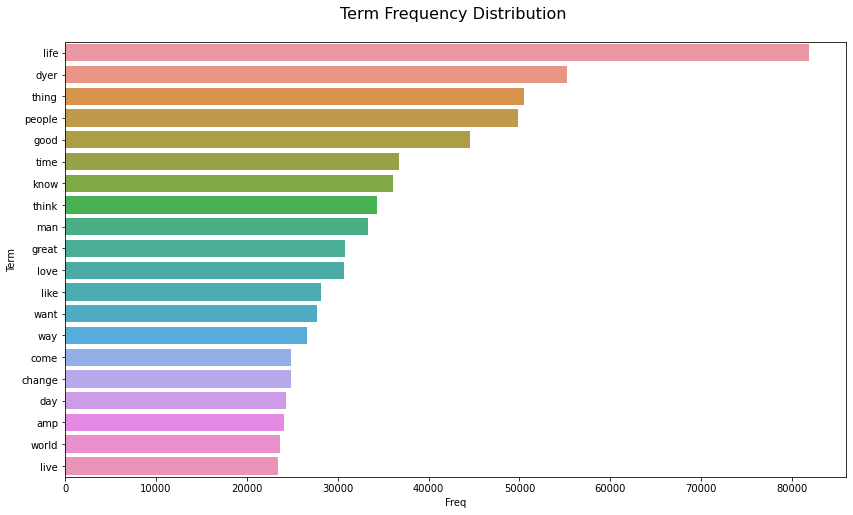

In [40]:
plt.figure(figsize=(14,8))
sns.barplot(data=freq.head(20), x='Freq', y='Term')
plt.title('Term Frequency Distribution \n', fontsize=16)
plt.show()

In [41]:
mask = np.array(Image.open('/content/drive/MyDrive/Data/NLP_Capstone/word_cloud_background.png'))

In [42]:
def wordcloud(text, colormap='tab10', background_color='white'):
  cloud = WordCloud(width=1600, height=800,
                    mask=None, 
                    stopwords=None, 
                    colormap=colormap, 
                    background_color=background_color).generate_from_frequencies(text)

  plt.figure(figsize=(12,10))
  plt.imshow(cloud)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.show()

In [43]:
# wordcloud needs terms and freq into dict form
word_dict = dict(zip(freq['Term'],freq['Freq']))

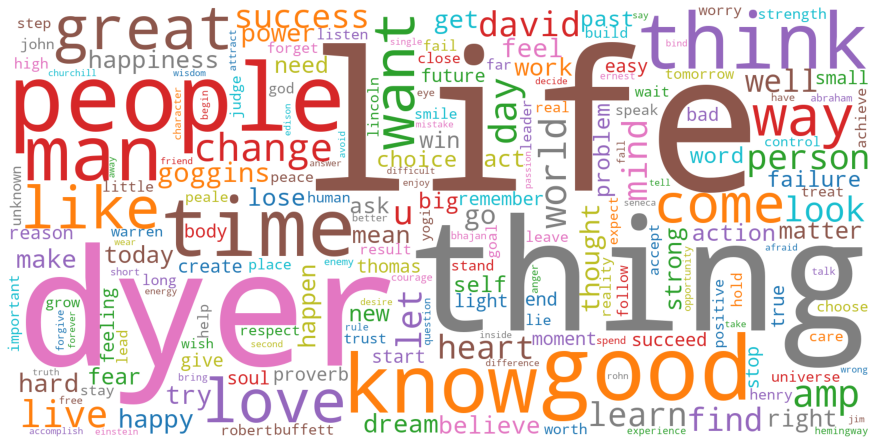

In [44]:
wordcloud(word_dict)

In [51]:
# Export dataframe into a CSV
tweets_cleaned.to_csv(r'/content/drive/MyDrive/Data/NLP_Capstone/motivational_tweets_cleaned3.csv', 
                      sep=',', 
                      index=True)

In [47]:
tweets_cleaned.head()

,date,user_name,display_name,content,content_preprocessed,tokenized
44,2021-01-17 22:13:17,LewisHowes,Lewis Howes,Know this. Everything is happening for a reason and in your favor for the betterment of your future. The pain you feel now will help later if you: 1. Look at what's not serving you 2. Listen to your intuition 3. Learn the meaning behind it 4. Let go of limits that hold you back,know happen reason favor betterment future pain feel help later look serve listen intuition learn meaning let limit hold,"[know, happen, reason, favor, betterment, future, pain, feel, help, later, look, serve, listen, intuition, learn, meaning, let, limit, hold]"
61,2021-01-15 15:28:06,LewisHowes,Lewis Howes,Protect your inner peace at all costs. Create daily practices and communicate boundaries to make sure the stress and drama of others doesn't consume you. You don't need to be someone else's emotional punching bag. Your energy and happiness is too important. Protect your peace!,protect inner peace cost create daily practice communicate boundary sure stress drama consume need emotional punching bag energy happiness important protect peace,"[protect, inner, peace, cost, create, daily, practice, communicate, boundary, sure, stress, drama, consume, need, emotional, punching, bag, energy, happiness, important, protect, peace]"
108,2021-01-12 16:40:46,LewisHowes,Lewis Howes,You are stronger than you think. The painful moments that hurt you in the past were meant for you. They broke you down so you could become stronger than ever before. I know it was hard. I know you wouldn't wish it on anyone else. But I also know you wouldn't change a thing!,strong think painful moment hurt past mean break strong know hard know wish know change thing,"[strong, think, painful, moment, hurt, past, mean, break, strong, know, hard, know, wish, know, change, thing]"
161,2021-01-07 16:00:29,LewisHowes,Lewis Howes,"Always remember to ask for exactly what you want. Ask for love, good health, abundance and peace. Ask for wisdom, creativity and positive energy. Don't be shy in your dreams. Be bold and live in gratitude because everything you want is coming to you.",remember ask exactly want ask love good health abundance peace ask wisdom creativity positive energy shy dream bold live gratitude want come,"[remember, ask, exactly, want, ask, love, good, health, abundance, peace, ask, wisdom, creativity, positive, energy, shy, dream, bold, live, gratitude, want, come]"
206,2021-01-05 00:11:24,LewisHowes,Lewis Howes,What if you treated yourself like someone you were madly in love with? Imagine what you could do with all that positive energy. Stop beating yourself up for not being perfect and start loving yourself the way you would with someone you care about.,treat like madly love imagine positive energy stop beat perfect start love way care,"[treat, like, madly, love, imagine, positive, energy, stop, beat, perfect, start, love, way, care]"


In [48]:
tweets_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694155 entries, 44 to 977610
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  694155 non-null  datetime64[ns]
 1   user_name             694155 non-null  object        
 2   display_name          694155 non-null  object        
 3   content               694155 non-null  object        
 4   content_preprocessed  694155 non-null  object        
 5   tokenized             694155 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 37.1+ MB


In [49]:
tweets_cleaned.shape

(694155, 6)

We have exported our cleaned and feature engineered data frame. Next step is topic modeling. Our model step can be found here.()